In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

import warnings
warnings.filterwarnings("ignore")

import itertools


# 1. Load Data 

In [ ]:
# Load the dataset
df = pd.read_parquet('../data/processed/electricity_sales.parquet')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   period  294 non-null    datetime64[ns]
 1   sales   294 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.7 KB


In [4]:
# Set period as index
df.set_index('period', inplace=True)

In [5]:
# Split data into training and testing sets
train_size = int(len(df) * 0.8)
train, test = df[0:train_size], df[train_size:]

print(f"Training data size: {len(train)}")
print(f"Testing data size: {len(test)}")

Training data size: 235
Testing data size: 59


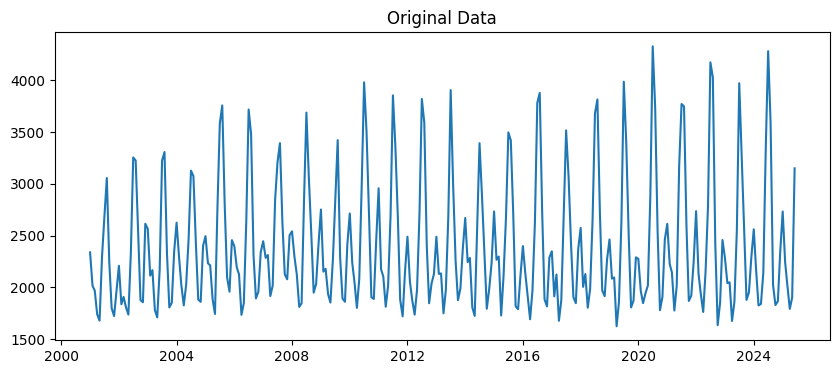

In [6]:
plt.figure(figsize=(10,4))
plt.plot(df.index, df["sales"])
plt.title("Original Data")
plt.show()

# 2. Models

### 2.1. Seasonal Naive

In [7]:
# Get predictions
seasonal_naive_pred = df.shift(12).loc[test.index]

# Get evaluation metrics
print("Seasonal naive metrics (20% test):")
print("MAE:", mean_absolute_error(test, seasonal_naive_pred))
print("RMSE:", np.sqrt(mean_squared_error(test, seasonal_naive_pred)))
print("MAPE (%):", mean_absolute_percentage_error(test, seasonal_naive_pred)*100)

Seasonal naive metrics (20% test):
MAE: 208.95928288135596
RMSE: 266.8934080748135
MAPE (%): 8.318699595031365


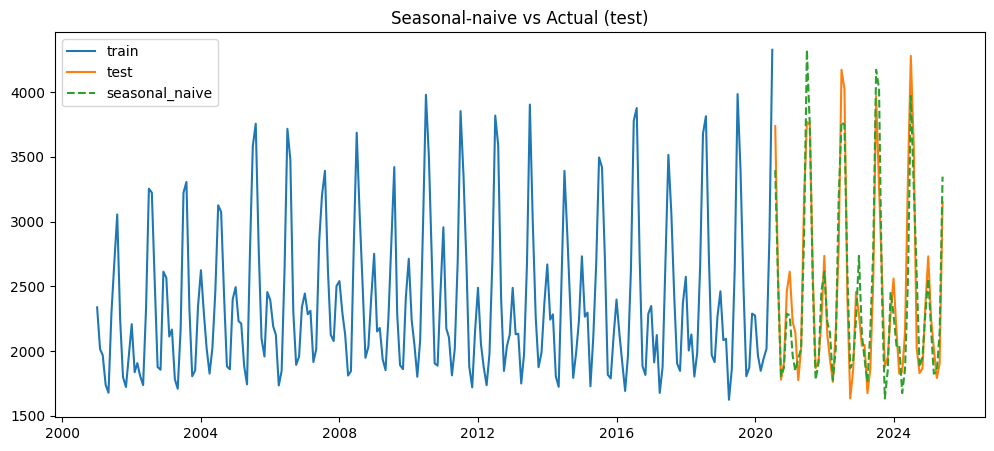

In [8]:
plt.figure(figsize=(12,5))
plt.plot(train.index, train, label='train')
plt.plot(test.index, test, label='test')
plt.plot(test.index, seasonal_naive_pred, '--', label='seasonal_naive')
plt.legend(); plt.title("Seasonal-naive vs Actual (test)"); plt.show()


### 2.2 SARIMA

##### 2.2.1 Deciding d, D (Check stationarity & decide order of differencing)

In [9]:
# Check for stationarity
def check_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput[f'Critical Value {key}'] = value
    print(dfoutput)

In [10]:
print("Stationarity Check on Original Data:")
check_stationarity(train['sales'])

Stationarity Check on Original Data:
Results of Dickey-Fuller Test:
Test Statistic                  -4.131654
p-value                          0.000858
#Lags Used                      13.000000
Number of Observations Used    221.000000
Critical Value 1%               -3.460291
Critical Value 5%               -2.874709
Critical Value 10%              -2.573789
dtype: float64


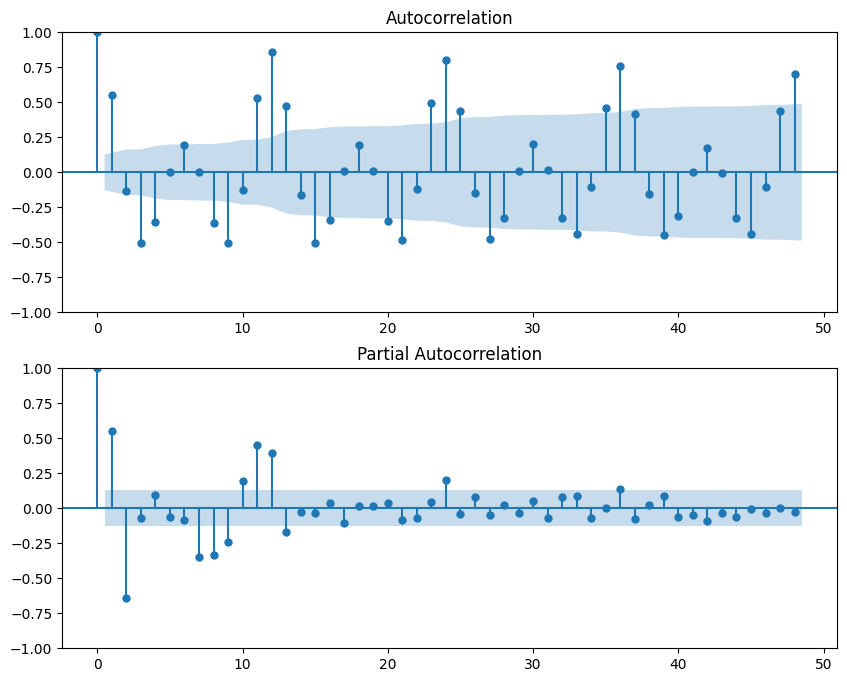

In [11]:
# ACF and PACF plots of the original data
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(train["sales"], ax=ax[0], lags=48)
plot_pacf(train["sales"], ax=ax[1], lags=48, method='ywm')
plt.show()

Even though the Dickey-Fuller test shows p < 0.05 (indicating stationarity), the presence of a clear seasonality suggests we should at least apply a seasonal differencing. 

In [12]:
# First, let's try seasonal differencing (12 months)
seasonal_diff = train['sales'].diff(12)
seasonal_diff = seasonal_diff.dropna()

In [13]:
print("Stationarity Check on Seasonally Differenced Data:")
check_stationarity(seasonal_diff)

Stationarity Check on Seasonally Differenced Data:
Results of Dickey-Fuller Test:
Test Statistic                -5.707474e+00
p-value                        7.430749e-07
#Lags Used                     1.200000e+01
Number of Observations Used    2.100000e+02
Critical Value 1%             -3.461879e+00
Critical Value 5%             -2.875404e+00
Critical Value 10%            -2.574159e+00
dtype: float64


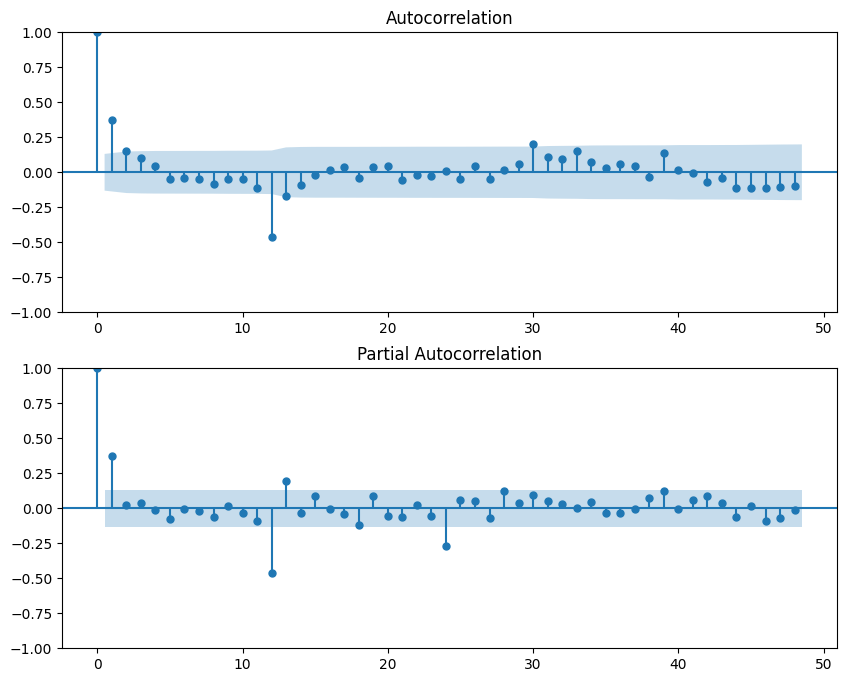

In [14]:
# ACF and PACF plots of the seasonally differenced data
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(seasonal_diff, ax=ax[0], lags=48)
plot_pacf(seasonal_diff, ax=ax[1], lags=48, method='ywm')
plt.show()

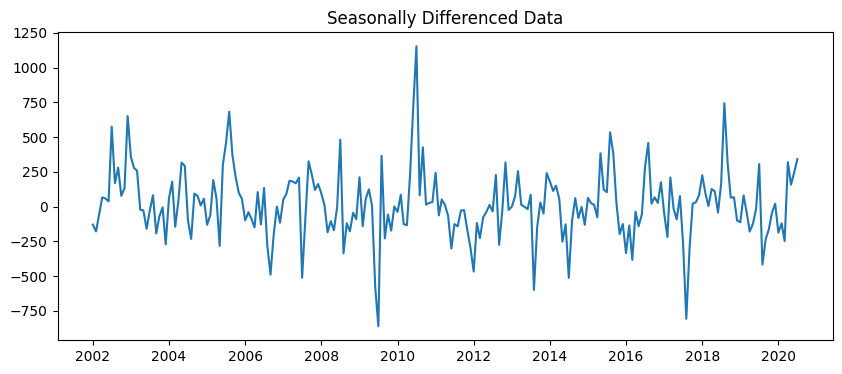

In [15]:
plt.figure(figsize=(10,4))
plt.plot(seasonal_diff.index, seasonal_diff)
plt.title("Seasonally Differenced Data")
plt.show()

Although I intialally decide to use d = 0, D = 1 at this point, the end model with these parameters give significant autocorrelation among its residuals. 
I decide to difference the data one more time. 

In [16]:
# Difference the seasonal differenced data again
diff_seasonal_diff = seasonal_diff.diff(1)
diff_seasonal_diff = diff_seasonal_diff.dropna()

In [17]:
print("Stationarity Check on Differenced Data:")
check_stationarity(diff_seasonal_diff)

Stationarity Check on Differenced Data:
Results of Dickey-Fuller Test:
Test Statistic                -7.021588e+00
p-value                        6.522266e-10
#Lags Used                     1.300000e+01
Number of Observations Used    2.080000e+02
Critical Value 1%             -3.462186e+00
Critical Value 5%             -2.875538e+00
Critical Value 10%            -2.574231e+00
dtype: float64


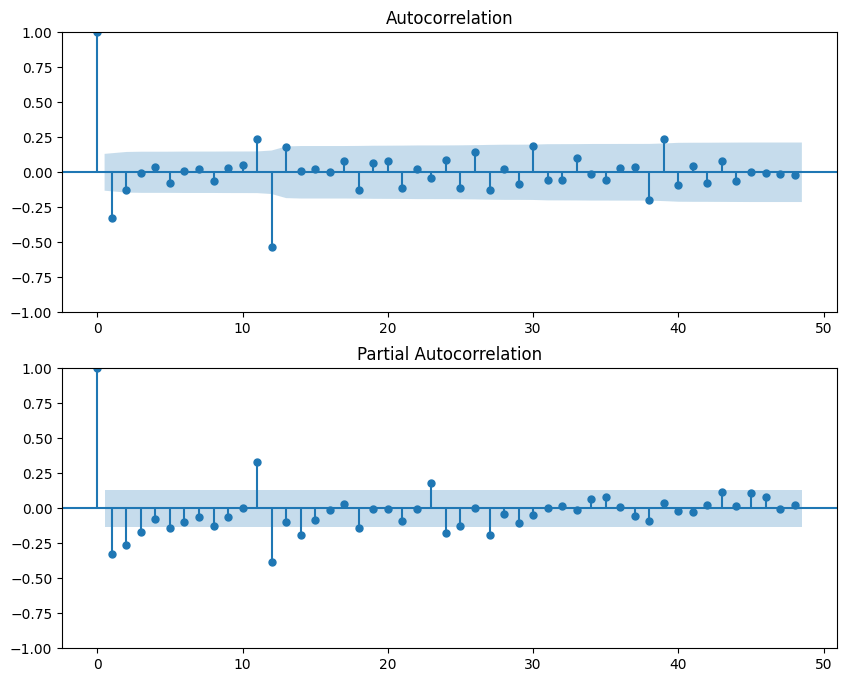

In [18]:
# ACF and PACF plots of the seasonally differenced data
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(diff_seasonal_diff, ax=ax[0], lags=48)
plot_pacf(diff_seasonal_diff, ax=ax[1], lags=48, method='ywm')
plt.show()

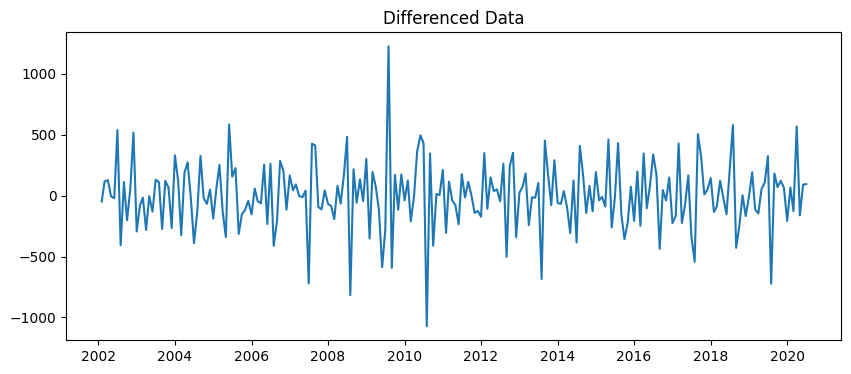

In [19]:
plt.figure(figsize=(10,4))
plt.plot(diff_seasonal_diff.index, diff_seasonal_diff)
plt.title("Differenced Data")
plt.show()

##### 2.2.2 Deciding p, q, P, Q

We run a small grid search for candidate values of p, q, P, Q obtained from the ACF / PACF plots. 

In [20]:
p_vals = [0,1]
d_vals = [1]        # d chosen above
q_vals = [0,1,2]
P_vals = [0,1]
D_vals = [1]        # D chosen above 
Q_vals = [0,1]

cfg_dict = {}


for p,d,q in itertools.product(p_vals, d_vals, q_vals):
    for P,D,Q in itertools.product(P_vals, D_vals, Q_vals):
        try:
            order = (p,d,q)
            seasonal_order = (P,D,Q,12)
            mod = SARIMAX(train["sales"], order=order, seasonal_order=seasonal_order,
                                            enforce_stationarity=False, enforce_invertibility=False)
            res = mod.fit(disp=False, maxiter=50)
            
            cfg_dict[(order, seasonal_order)] = res.aic
            print(f'SARIMA{order}x{seasonal_order} - AIC:{res.aic}')
        except Exception:
            continue



SARIMA(0, 1, 0)x(0, 1, 0, 12) - AIC:3112.905725682623
SARIMA(0, 1, 0)x(0, 1, 1, 12) - AIC:2830.2524953840552
SARIMA(0, 1, 0)x(1, 1, 0, 12) - AIC:2877.55469710982
SARIMA(0, 1, 0)x(1, 1, 1, 12) - AIC:2829.2617168913953
SARIMA(0, 1, 1)x(0, 1, 0, 12) - AIC:3052.295495411152
SARIMA(0, 1, 1)x(0, 1, 1, 12) - AIC:2786.8692238303156
SARIMA(0, 1, 1)x(1, 1, 0, 12) - AIC:2851.2020111174907
SARIMA(0, 1, 1)x(1, 1, 1, 12) - AIC:2788.368772077165
SARIMA(0, 1, 2)x(0, 1, 0, 12) - AIC:3017.0255246954302
SARIMA(0, 1, 2)x(0, 1, 1, 12) - AIC:2753.42359224908
SARIMA(0, 1, 2)x(1, 1, 0, 12) - AIC:2823.026625869984
SARIMA(0, 1, 2)x(1, 1, 1, 12) - AIC:2754.3649041000363
SARIMA(1, 1, 0)x(0, 1, 0, 12) - AIC:3089.5677177057637
SARIMA(1, 1, 0)x(0, 1, 1, 12) - AIC:2814.587826953867
SARIMA(1, 1, 0)x(1, 1, 0, 12) - AIC:2852.6144864888247
SARIMA(1, 1, 0)x(1, 1, 1, 12) - AIC:2815.115183202407
SARIMA(1, 1, 1)x(0, 1, 0, 12) - AIC:3025.7490159867875
SARIMA(1, 1, 1)x(0, 1, 1, 12) - AIC:2762.155470227107
SARIMA(1, 1, 1)x(1, 1

In [21]:
cfg_dict = dict(sorted(cfg_dict.items(), key=lambda item: item[1]))
print("\nTop 5 SARIMA configurations by AIC:")  
for i, (cfg, aic) in enumerate(cfg_dict.items()):
    if i >= 5:
        break
    print(f'{cfg} - AIC:{aic}')


Top 5 SARIMA configurations by AIC:
((1, 1, 2), (0, 1, 1, 12)) - AIC:2751.636760513093
((1, 1, 2), (1, 1, 1, 12)) - AIC:2752.586937855436
((0, 1, 2), (0, 1, 1, 12)) - AIC:2753.42359224908
((0, 1, 2), (1, 1, 1, 12)) - AIC:2754.3649041000363
((1, 1, 1), (0, 1, 1, 12)) - AIC:2762.155470227107


Here we choose the model with the 2nd lowest AIC value: (1, 1, 2), (1, 1, 1, 12), which is consistent with the ACF / PACF plots.


In [22]:
best_cfg = list(cfg_dict.keys())[1]
best_cfg

((1, 1, 2), (1, 1, 1, 12))

In [23]:
# Fit `best_cfg` on the train data for evaluation
order, seasonal_order = best_cfg
sarima_model = SARIMAX(train, order=order, seasonal_order=seasonal_order,
                                enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
print(sarima_model.summary())


                                      SARIMAX Results                                       
Dep. Variable:                                sales   No. Observations:                  235
Model:             SARIMAX(1, 1, 2)x(1, 1, [1], 12)   Log Likelihood               -1370.293
Date:                              Mon, 01 Sep 2025   AIC                           2752.587
Time:                                      22:21:10   BIC                           2772.583
Sample:                                  01-01-2001   HQIC                          2760.673
                                       - 07-01-2020                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3533      0.188      1.884      0.060      -0.014       0.721
ma.L1         -0.88

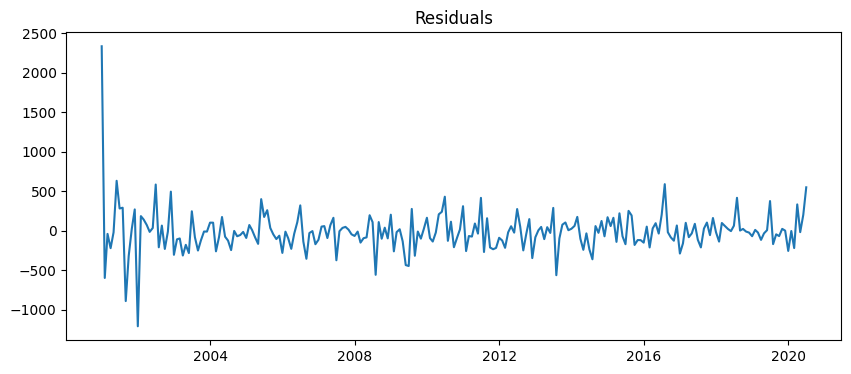

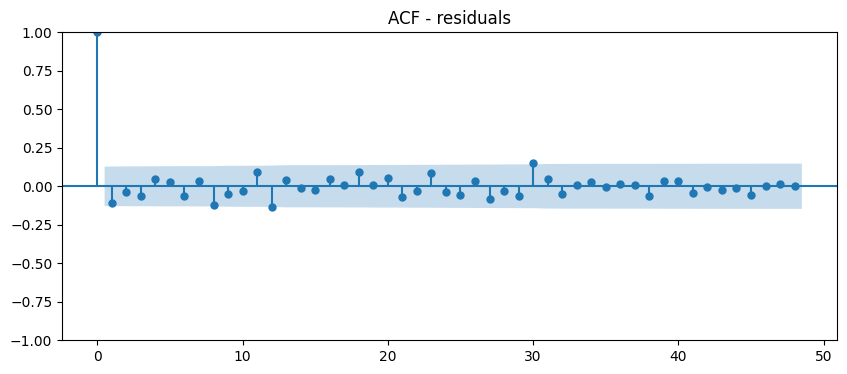

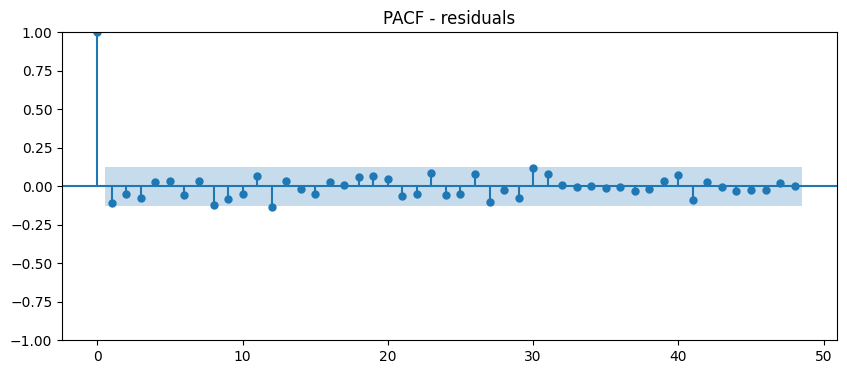

Ljung-Box (lag=12):
      lb_stat  lb_pvalue
12  17.689965   0.125434


In [24]:
# check residuals 
residuals = sarima_model.resid.dropna()

plt.figure(figsize=(10,4))
plt.plot(residuals); plt.title("Residuals"); plt.show()

plt.figure(figsize=(10,4)); plot_acf(residuals, lags=48, ax=plt.gca()); plt.title("ACF - residuals"); plt.show()
plt.figure(figsize=(10,4)); plot_pacf(residuals, lags=48, ax=plt.gca(), method='ywm'); plt.title("PACF - residuals"); plt.show()

# Ljung-Box test for no autocorrelation in residuals:
lb = acorr_ljungbox(residuals, lags=[12], return_df=True)
print("Ljung-Box (lag=12):")
print(lb)


The residuals show no significant autocorrelations. The model is ready for evaluation!  

##### 2.2.3 Evaluation

In [25]:
# Make predictions

# Here, we are making 1-step ahead forecasts in a rolling manner. 
# After each prediction, we append the actual observation from the test set to the model without refitting.

sarimax_pred = []

for i in range(len(test)):
    pred = sarima_model.forecast(steps=1)
    sarimax_pred.append(pred.values[0])
    sarima_model = sarima_model.append(test.iloc[i:i+1,0], refit=False)

# Convert predictions to a pandas Series with the same index as test
sarimax_pred = pd.Series(sarimax_pred, index=test.index)

In [26]:
# Get evaluation metrics

print("Seasonal naive metrics (20% test):")
print("MAE:", mean_absolute_error(test, sarimax_pred))
print("RMSE:", np.sqrt(mean_squared_error(test, sarimax_pred)))
print("MAPE (%):", mean_absolute_percentage_error(test, sarimax_pred)*100)

Seasonal naive metrics (20% test):
MAE: 149.04210170983927
RMSE: 197.41104886726595
MAPE (%): 5.910937484382501


Recall that the MAPE (%) for the seasonal naive forecast was 8.3%. We are seeing an improvement with the SARIMA model. 

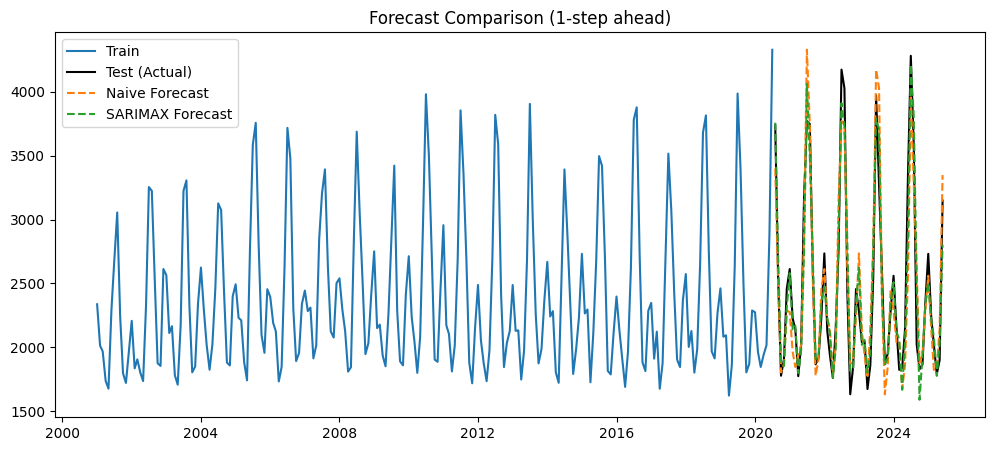

In [27]:
plt.figure(figsize=(12,5))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test (Actual)", color="black")
plt.plot(test.index, seasonal_naive_pred, label="Naive Forecast", linestyle="--")
plt.plot(test.index, sarimax_pred, label="SARIMAX Forecast", linestyle="--")
plt.legend()
plt.title("Forecast Comparison (1-step ahead)")
plt.show()


### 2.3 ETS

##### 2.3.1 STL Decomposition

<Figure size 1200x600 with 0 Axes>

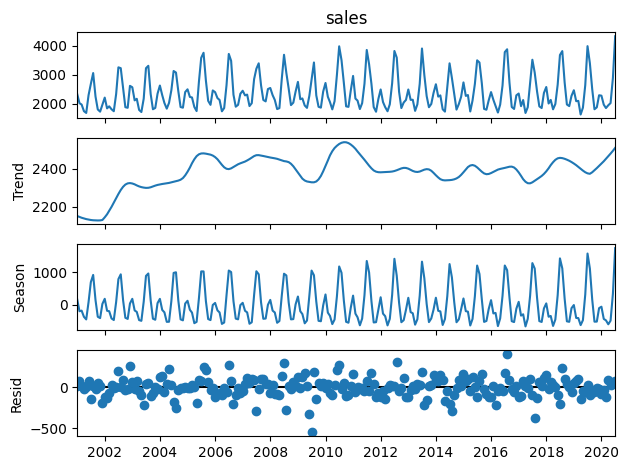

In [28]:
# Decompose to inspect trend and seasonality
decomp = STL(train["sales"]).fit()

plt.figure(figsize=(12,6))
decomp.plot()
plt.show()

The STL decomposition suggests a trend (slightly increasing) and seasonality (slightly increasing in variance)

##### 2.3.2 Deciding ETS Configurations

In [29]:
error_vals = ['add', 'mul']
trend_vals = [None, 'add'] # Some sources suggest avoiding multiplicative trends
damped_trend_vals = [False, True]
seasonal_vals = [None, 'add', 'mul']

cfg_dict = {}

for e,t,d,s in itertools.product(error_vals, trend_vals, damped_trend_vals, seasonal_vals):
    try:
        mod = ETSModel(train['sales'], error=e, trend=t, damped_trend=d, seasonal=s, seasonal_periods=12)
        res = mod.fit()
        
        cfg_dict[(e,t,d,s)] = res.aic
        print(f'ETS error: {e}, trend: {t}, damped {d}, seasonal {s} - AIC:{res.aic}')
    except Exception:
        continue


ETS error: add, trend: None, damped False, seasonal None - AIC:3672.4343523914927
ETS error: add, trend: None, damped False, seasonal add - AIC:3151.137837335733
ETS error: add, trend: None, damped False, seasonal mul - AIC:3118.6199608523716
ETS error: add, trend: add, damped False, seasonal None - AIC:3672.9863006127325
ETS error: add, trend: add, damped False, seasonal add - AIC:3336.291203938584
ETS error: add, trend: add, damped False, seasonal mul - AIC:3122.410886874671
ETS error: add, trend: add, damped True, seasonal None - AIC:3666.817104409043
ETS error: add, trend: add, damped True, seasonal add - AIC:3328.373761332665
ETS error: add, trend: add, damped True, seasonal mul - AIC:3133.353111019618
ETS error: mul, trend: None, damped False, seasonal None - AIC:3672.2626582287044
ETS error: mul, trend: None, damped False, seasonal add - AIC:3260.343154073123
ETS error: mul, trend: None, damped False, seasonal mul - AIC:3062.197574292214
ETS error: mul, trend: add, damped False,

In [30]:
cfg_dict = dict(sorted(cfg_dict.items(), key=lambda item: item[1]))
print("\nTop 5 ETS configurations by AIC:")  
for i, (cfg, aic) in enumerate(cfg_dict.items()):
    if i >= 5:
        break
    print(f'{cfg} - AIC:{aic}')


Top 5 ETS configurations by AIC:
('mul', None, False, 'mul') - AIC:3062.197574292214
('mul', 'add', False, 'mul') - AIC:3065.0563891080237
('mul', 'add', True, 'mul') - AIC:3067.1153650502447
('add', None, False, 'mul') - AIC:3118.6199608523716
('add', 'add', False, 'mul') - AIC:3122.410886874671


Here, I initially decide to use the 3rd model (Multiplicative Errors, Damped Additive Trend, Multiplicative Seasonality). 
The STL decomposition suggests there is some trend in the data altough it may not be linear (thus we use the damped additive trend). <br> 

However, the Ljung-Box test shows that the residuals of this model have significant autocorrelation. In fact, this is the case for all model configurations I explore. I show one such example below. <br> 

At this point, I decide to not consider ETS as an alternative forecasting method further and stick to the SARIMA model developed in Section 2.2. 

In [32]:
best_cfg = list(cfg_dict.keys())[2]
best_cfg

('mul', 'add', True, 'mul')

In [33]:
# Fit `best_cfg` on the train data for evaluation
error, trend, damp, seasonal = best_cfg
# error, trend, damp, seasonal = ('mul', None, False, 'mul')

ets_model = ETSModel(train["sales"], error=error, trend=trend, damped_trend=damp, seasonal=seasonal, seasonal_periods=12).fit()
print(ets_model.summary())

                                 ETS Results                                  
Dep. Variable:                  sales   No. Observations:                  235
Model:                      ETS(MAdM)   Log Likelihood               -1514.558
Date:                Mon, 01 Sep 2025   AIC                           3067.115
Time:                        22:23:09   BIC                           3132.847
Sample:                    01-01-2001   HQIC                          3093.616
                         - 07-01-2020   Scale                            0.004
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.4479      0.104      4.320      0.000       0.245       0.651
smoothing_trend      4.479e-05      0.010      0.004      0.997      -0.020       0.020
smoothing_season

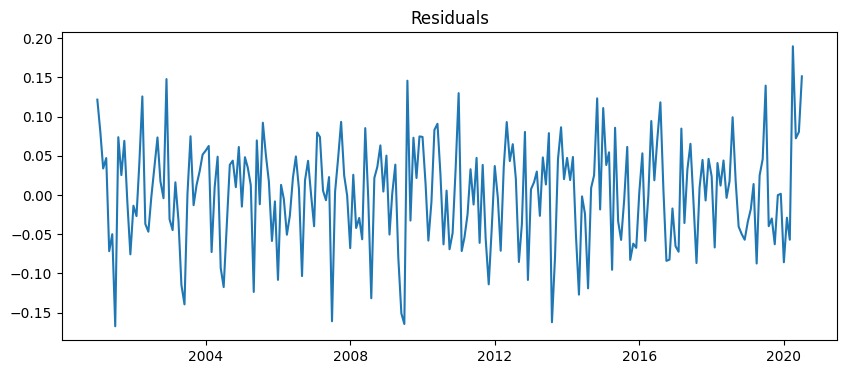

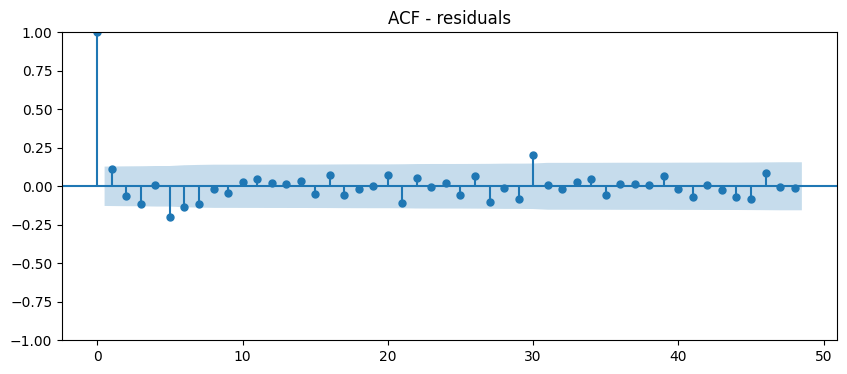

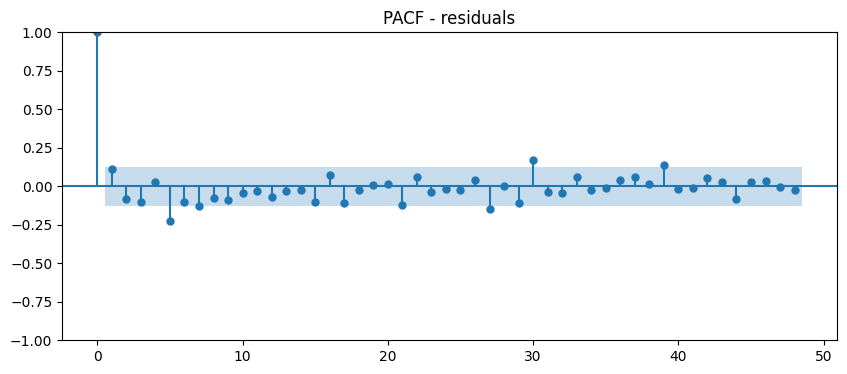

Ljung-Box (lag=12):
      lb_stat  lb_pvalue
12  26.172438   0.010147


In [34]:
# check residuals 
residuals = ets_model.resid.dropna()

plt.figure(figsize=(10,4))
plt.plot(residuals); plt.title("Residuals"); plt.show()

plt.figure(figsize=(10,4)); plot_acf(residuals, lags=48, ax=plt.gca()); plt.title("ACF - residuals"); plt.show()
plt.figure(figsize=(10,4)); plot_pacf(residuals, lags=48, ax=plt.gca(), method='ywm'); plt.title("PACF - residuals"); plt.show()

# Ljung-Box test for no autocorrelation in residuals:
lb = acorr_ljungbox(residuals, lags=[12], return_df=True)
print("Ljung-Box (lag=12):")
print(lb)

As described above, the residuals show significant autocorrelations. I decide not to go down this path further. <br> 

Had I decided to go down this path, I would have encountered another challenge. The ETSModel I am using does not support the .append method so I would have had to implement the rolling evaluation a different way. Alternatively, statsmodels.tsa.statespace.exponential_smoothing.ExponentialSmoothing seems to support the append method but it does not allow multiplicative models. <br> 

Another alternative worth exploring would be to use the Statsforecast library from Nixtla. I keep that as a future enhancement opportunity.  